In [35]:
from NirsLabProject.config.consts import *
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils import general_utils as utils
from NirsLabProject.utils import scalp_spikes_detection
from NirsLabProject.utils import intracranial_spikes_detection
from NirsLabProject.utils import pipeline_utils
from NirsLabProject.utils.sleeping_utils import *
from NirsLabProject.utils import plotting
from NirsLabProject.config.paths import Paths

import scipy.stats as sp_stats
import matplotlib.pyplot as plt
from functools import partial
from scipy.signal import find_peaks
import numpy as np
from mne_features.feature_extraction import extract_features


In [36]:
subject = Subject('p485', bipolar_model=True)

In [37]:
raw = pipeline_utils.resample_and_filter_data(subject)

Reading raw data...
Data for electrode LMH was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['LMH1', 'LMH2', 'LMH3', 'LMH4', 'LMH5', 'LMH6', 'LMH7'] channels, 1000.0 Hz
Data for electrode LOF was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['LOF1', 'LOF2', 'LOF3', 'LOF4', 'LOF5', 'LOF6', 'LOF7'] channels, 1000.0 Hz
Data for electrode RBAA was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['RBAA1', 'RBAA2', 'RBAA3', 'RBAA4', 'RBAA5', 'RBAA6', 'RBAA7'] channels, 1000.0 Hz
Data for electrode ROF was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['ROF1', 'ROF2', 'ROF3', 'ROF4', 'ROF5', 'ROF6', 'ROF7'] channels, 1000.0 Hz
Data for electrode RPHG was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['RPHG1', 'RPHG2', 'RPHG3', 'RPHG4', 'RPHG5', 'RPHG6', 'RPHG7'] chan

In [38]:

    if 'EOG' in raw.keys():
        eog_raw = raw.pop('EOG')
    else:
        eog_raw = None

    # detects intracranial spikes
    intracranial_spikes_spikes_windows = intracranial_spikes_detection.detect_spikes_of_subject(subject, raw)

Detecting Intracranial spikes for subject p485
Spikes already detected for subject p485


In [39]:
raw_electrode = raw['LMH']
channel_name = 'LMH1'
spikes_windows = dict(intracranial_spikes_spikes_windows)

In [89]:
def get_spike_amplitude_and_length(data: np.ndarray, peak_index):
    # taking the spike range (SPIKE_RANGE_SECONDS) before and after the peak timestamp of the window
    spike_range_in_indexes = int(SPIKE_RANGE_SECONDS * SR)
    start_frame_index = max(0, peak_index-spike_range_in_indexes)
    end_frame_index = min(len(data), peak_index+spike_range_in_indexes)
    
    
    amplitude = data[peak_index]
    baseline = np.mean(data[start_frame_index:peak_index])
    relative_amp = amplitude - baseline
    
    # finding the closest point before the peak with half of the peak amplitude
    first_half_start = start_frame_index + np.where(data[start_frame_index:peak_index] < amplitude / 2)[0]
    if len(first_half_start) > 0:
        first_half_start = first_half_start[-1]
    else:
        # if there is no point before the peak with half of the peak amplitude, we will take the start of the window
        return {'index': peak_index, 'amplitude': amplitude, 'length': -1, 'relative_amp': relative_amp}
    
    # finding the closest point after the peak with half of the peak amplitude
    second_half_end = peak_index + np.where(data[peak_index:end_frame_index] < amplitude / 2)[0]
    if len(second_half_end) > 0:
        second_half_end = second_half_end[0]
    else:
        # if there is no point after the peak with half of the peak amplitude, we will take the end of the window
        return {'index': peak_index, 'amplitude': amplitude, 'length': -1, 'relative_amp': relative_amp}
    
    relative_first_half_start = start_frame_index + np.where(data[start_frame_index:peak_index] < (amplitude+baseline) / 2)[0]
    if len(relative_first_half_start) > 0:
        relative_first_half_start = relative_first_half_start[-1]
    else:
        # if there is no point before the peak with half of the peak amplitude, we will take the start of the window
        print('dasdasdasdasdadadas')
        return {'index': peak_index, 'amplitude': amplitude, 'length': -1, 'relative_amp': relative_amp}
    
    # finding the closest point after the peak with half of the peak amplitude
    relative_second_half_end = peak_index + np.where(data[peak_index:end_frame_index] < (amplitude+baseline) / 2)[0]
    if len(relative_second_half_end) > 0:
        relative_second_half_end = relative_second_half_end[0]
    else:
        # if there is no point after the peak with half of the peak amplitude, we will take the end of the window
        print('dasdasdasdasdadadas')
        return {'index': peak_index, 'amplitude': amplitude, 'length': -1, 'relative_amp': relative_amp}
    
    
    xp, yp = (spike_range_in_indexes, data[peak_index])
    x1, y1 = (first_half_start-peak_index+spike_range_in_indexes, data[first_half_start])
    x2, y2 = (second_half_end-peak_index+spike_range_in_indexes, data[second_half_end])
    
    relative_x1, relative_y1 = (relative_first_half_start-peak_index+spike_range_in_indexes, data[relative_first_half_start])
    relative_x2, relative_y2 = (relative_second_half_end-peak_index+spike_range_in_indexes, data[relative_second_half_end])
    
    delta_x = xp - x1
    delta_y = yp - y1
    slope = (delta_y / delta_x) 
    slope_angle = np.degrees(np.arctan(slope))

    
    relative_length = relative_second_half_end - relative_first_half_start
    if not (MIN_SPIKE_LENGTH_MILLISECONDS <= relative_length <= MAX_SPIKE_LENGTH_MILLISECONDS):
        print('here:')
        print({
        'index': peak_index,
        'amplitude': amplitude,
        'length': second_half_end - first_half_start,
        'angle': slope_angle,
        'relative_amp': relative_amp,
        'relative_length': relative_length
        })
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(data[start_frame_index:end_frame_index], color='b')
        plt.scatter(xp, yp, color='green', label='Single Point')
        plt.scatter(x1, y1, color='r', label='Single Point')
        plt.scatter(x2, y2, color='r', label='Single Point')
        plt.scatter(relative_x1, relative_y1, color='b', label='Single Point')
        plt.scatter(relative_x2, relative_y2, color='b', label='Single Point')
        plt.axhline(y=baseline, color='orange', label='Width')

        # Display the angle as text on the plot
        plt.text(x1 + 0.5 * delta_x, y1 + 0.5 * delta_y, f'relative_amp: {amplitude-baseline:.2f} | amplitude: {amplitude:.2f}', color='black', fontsize=10)
    return {
        'index': peak_index,
        'amplitude': amplitude,
        'length': second_half_end - first_half_start,
        'angle': slope_angle,
        'relative_amp': relative_amp,
        'relative_length': relative_length
    }



def extract_spikes_peaks_features(channel_data: np.ndarray, spikes: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    spikes = np.unique(spikes).flatten()

    if spikes.shape[0] == 0:
        return np.array([]), np.array([])

#     Vectorized feature extraction using np.vectorize
    
    v_extract_features = np.vectorize(partial(get_spike_amplitude_and_length, channel_data))
    
    # Perform feature extraction on all indexes at once
    features_array = v_extract_features(spikes)

    peaks = np.array([d['amplitude'] for d in features_array])
    lengths = np.array([d['length'] for d in features_array])
    angles = np.array([d['angle'] for d in features_array])
    relative_peaks = np.array([d['relative_amp'] for d in features_array])
    relative_lenghts = np.array([d['relative_length'] for d in features_array])

    return peaks, lengths, angles, relative_peaks, relative_lenghts

here:
{'index': 6522222, 'amplitude': 4.0791639448065, 'length': 57, 'angle': 4.406530822340247, 'relative_amp': 4.290508757305377, 'relative_length': 74}
here:
{'index': 6639301, 'amplitude': 3.011023891962664, 'length': 58, 'angle': 4.895143235647517, 'relative_amp': 3.4966286921654404, 'relative_length': 84}
here:
{'index': 6664252, 'amplitude': 1.9748031616169766, 'length': 49, 'angle': 2.207607256439662, 'relative_amp': 2.5334846234658985, 'relative_length': 77}
here:
{'index': 6673359, 'amplitude': 2.1605840189560817, 'length': 53, 'angle': 3.491052356837429, 'relative_amp': 2.7083336294773868, 'relative_length': 119}
here:
{'index': 6690054, 'amplitude': 2.0664265574436365, 'length': 65, 'angle': 1.3981338713285592, 'relative_amp': 2.6434368842706157, 'relative_length': 72}
here:
{'index': 6733443, 'amplitude': 1.4761750772607312, 'length': 70, 'angle': 1.7392439692891035, 'relative_amp': 2.148811358664153, 'relative_length': 79}
here:
{'index': 6755762, 'amplitude': 1.744022828

here:
{'index': 18756949, 'amplitude': 1.042640598850953, 'length': 24, 'angle': 5.96894473083313, 'relative_amp': 2.264724399609147, 'relative_length': 127}
here:
{'index': 18825243, 'amplitude': 1.511002694119027, 'length': 41, 'angle': 2.7579417692797685, 'relative_amp': 3.2980498996267453, 'relative_length': 71}
here:
{'index': 19288169, 'amplitude': 1.6564411431975752, 'length': 66, 'angle': 1.0520584656556504, 'relative_amp': 2.534955670844376, 'relative_length': 95}
here:
{'index': 19291328, 'amplitude': 1.7177199278655193, 'length': 32, 'angle': 4.333628179786389, 'relative_amp': 0.6599827687002024, 'relative_length': 19}
here:
{'index': 19310195, 'amplitude': 1.415260616124404, 'length': 25, 'angle': 6.626528114973036, 'relative_amp': 0.6178523315849159, 'relative_length': 18}
here:
{'index': 19362158, 'amplitude': 2.11354800412795, 'length': 61, 'angle': 4.343769353786303, 'relative_amp': 2.5776555185975245, 'relative_length': 84}
here:
{'index': 20028675, 'amplitude': 2.6819

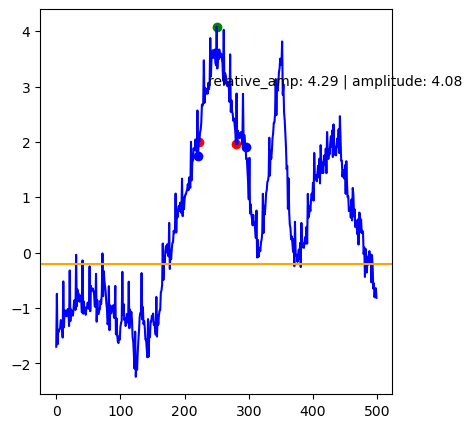

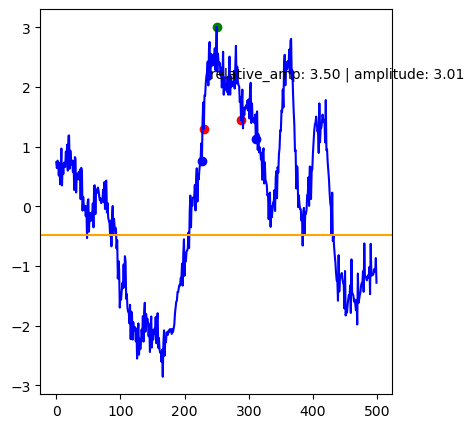

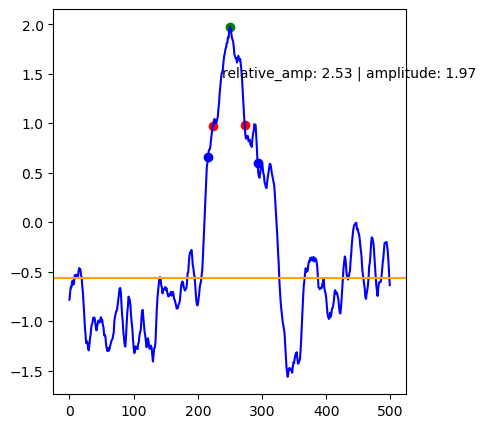

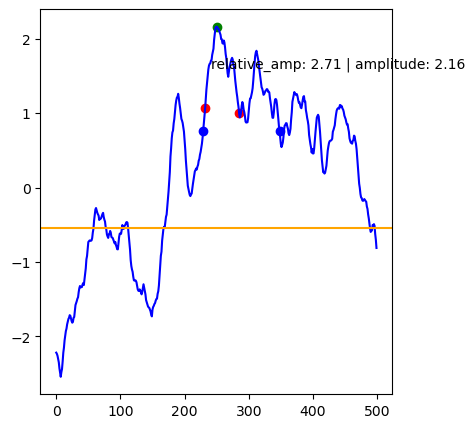

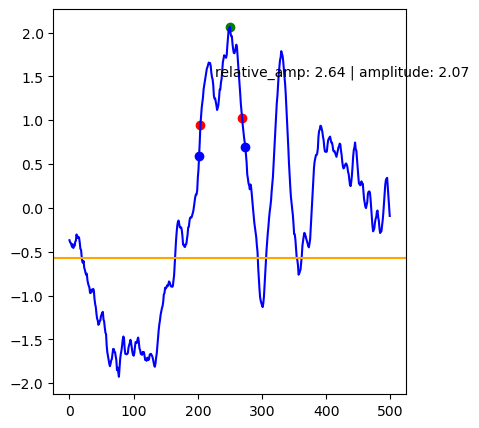

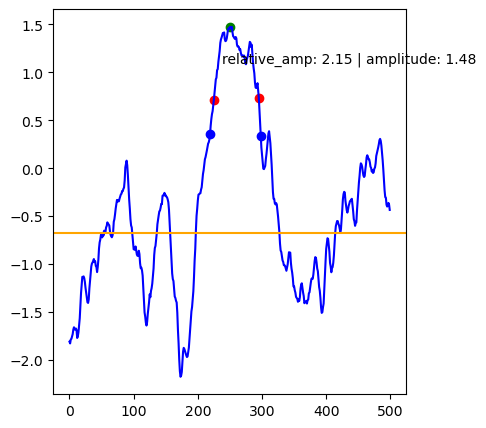

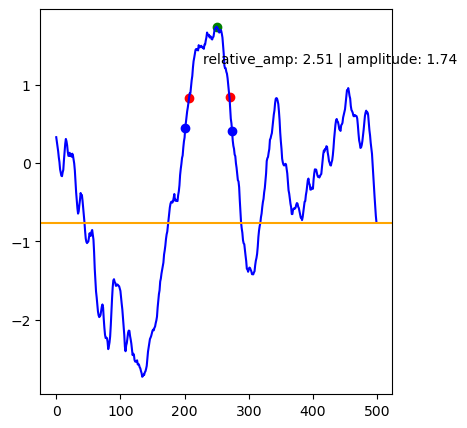

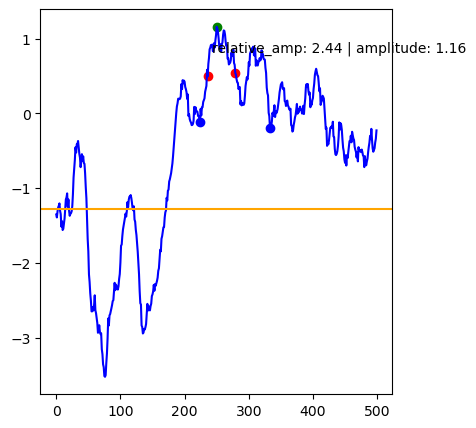

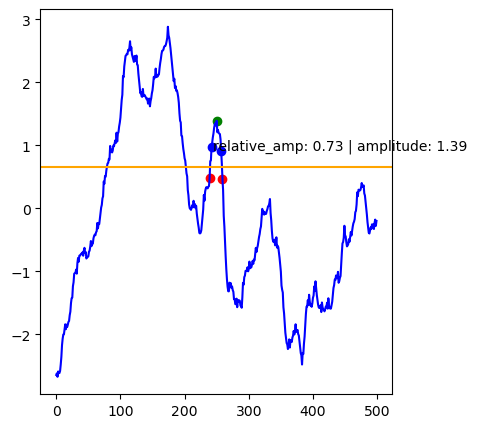

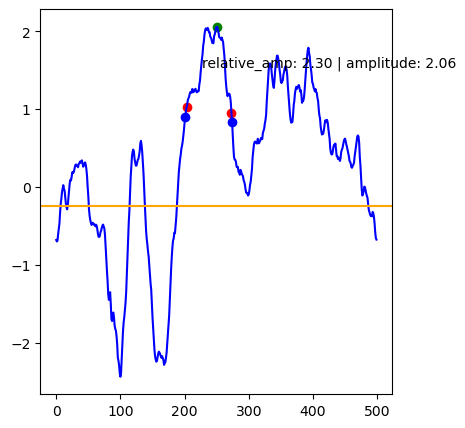

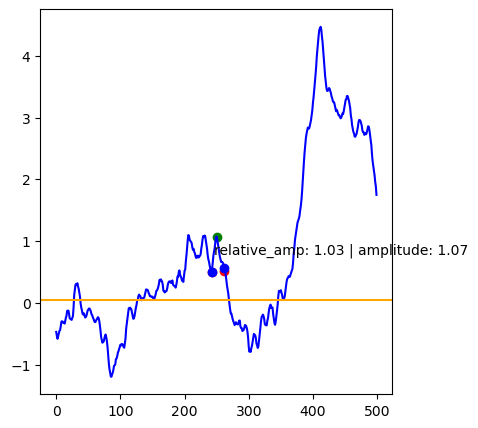

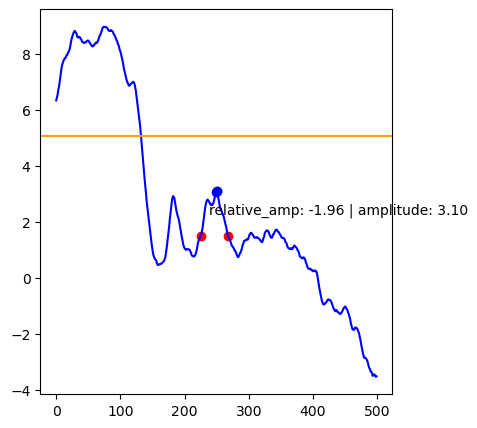

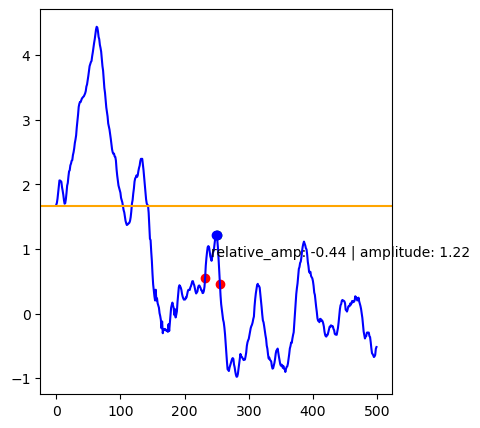

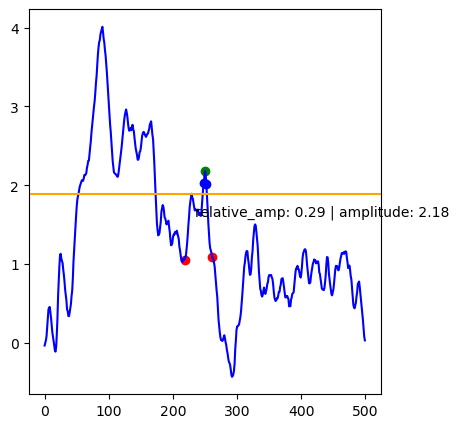

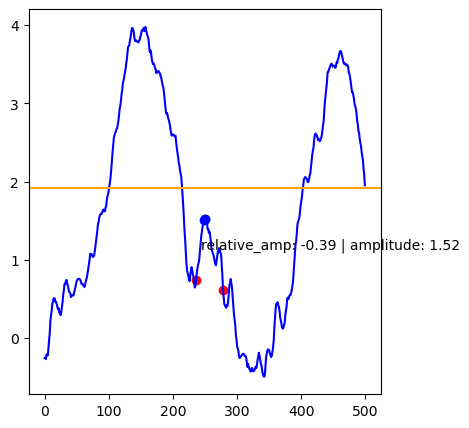

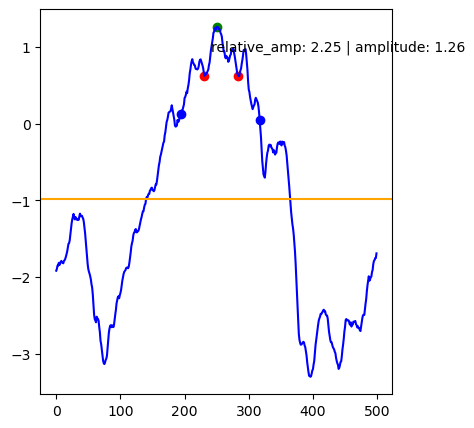

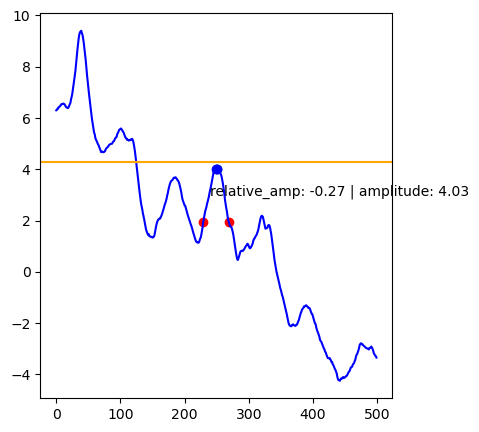

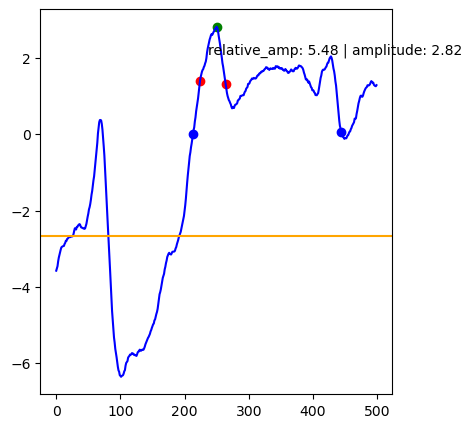

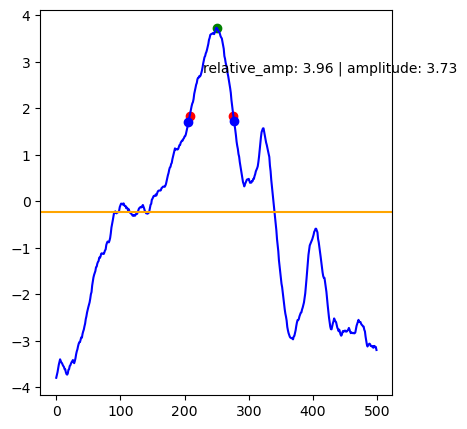

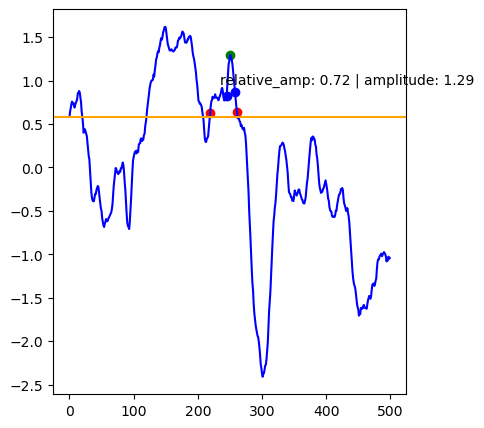

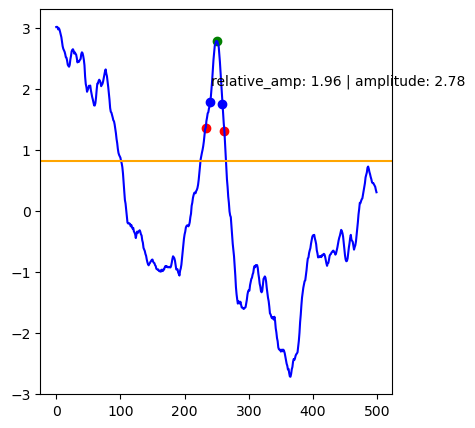

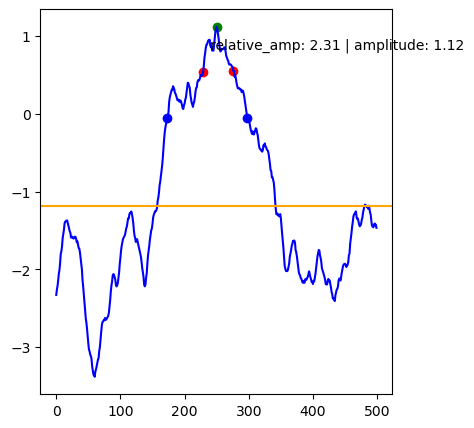

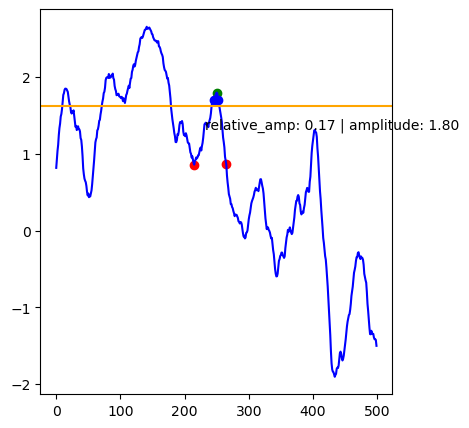

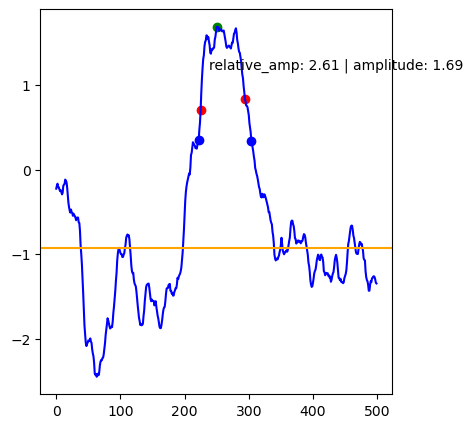

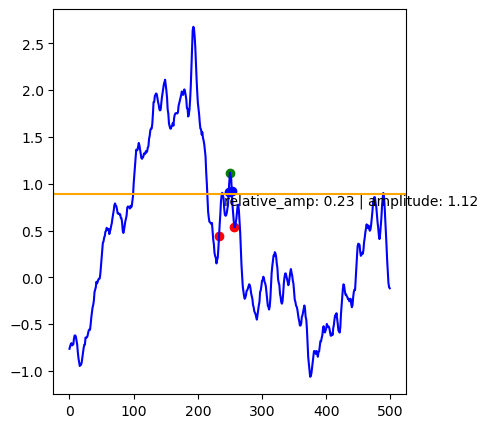

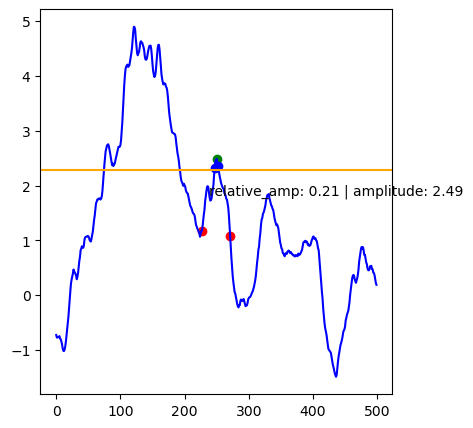

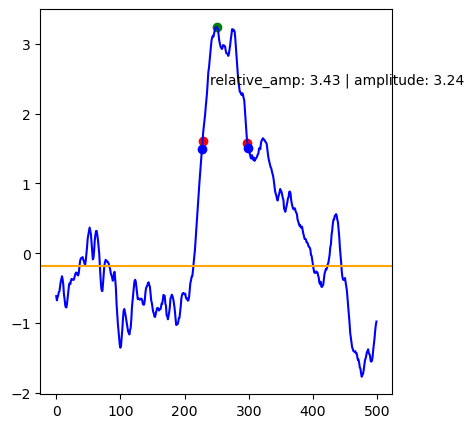

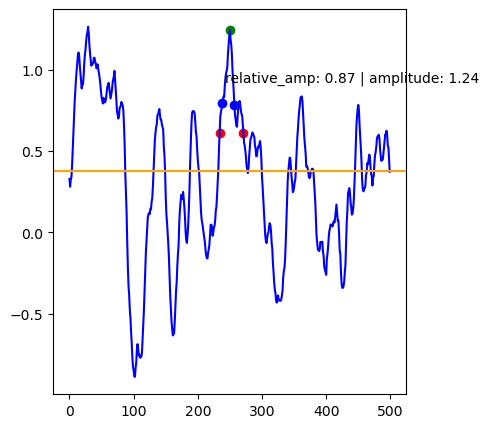

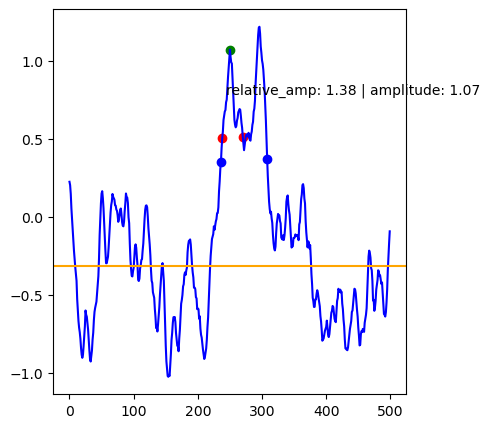

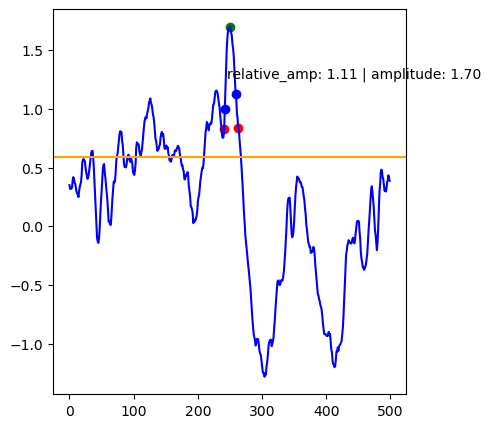

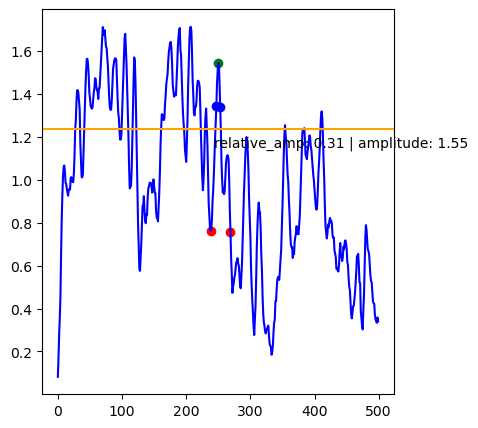

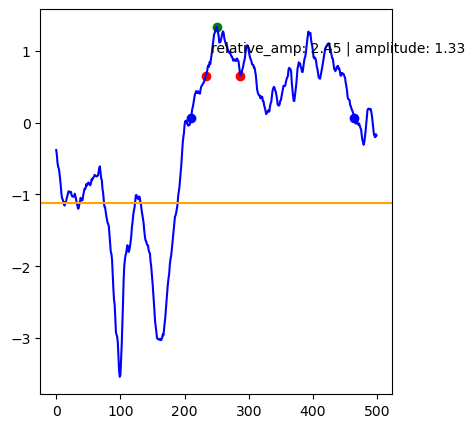

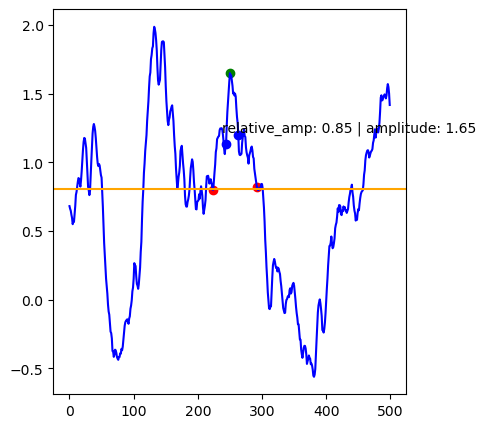

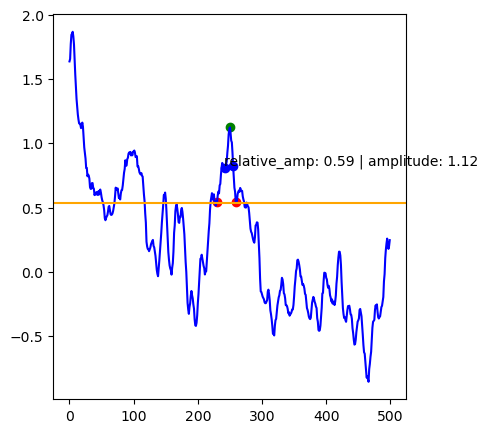

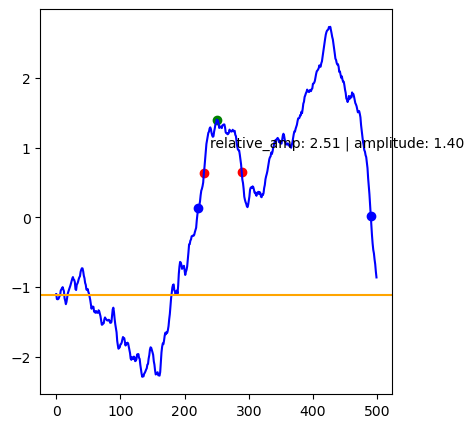

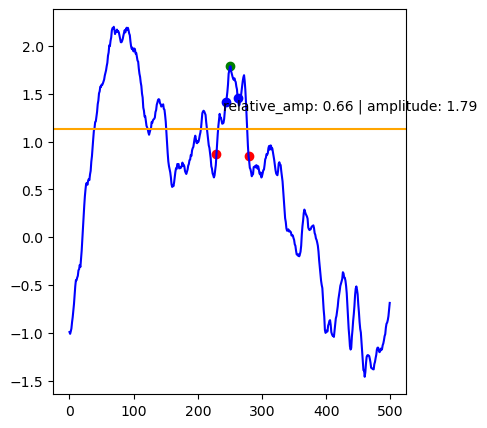

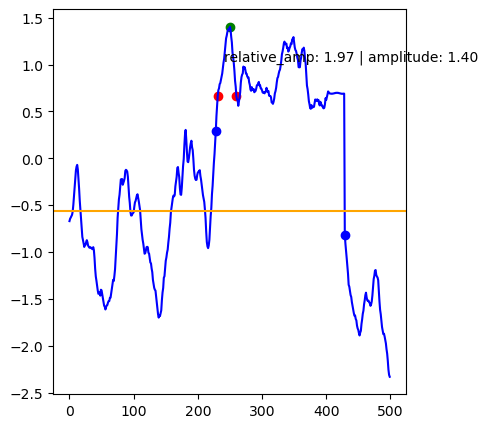

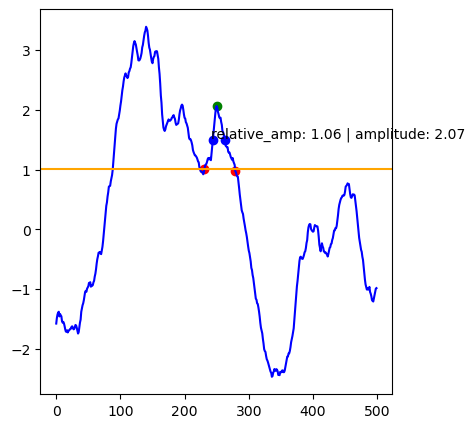

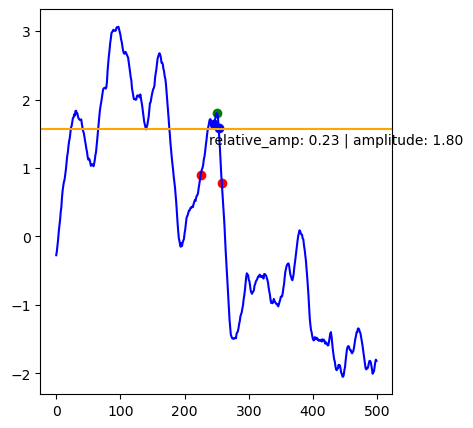

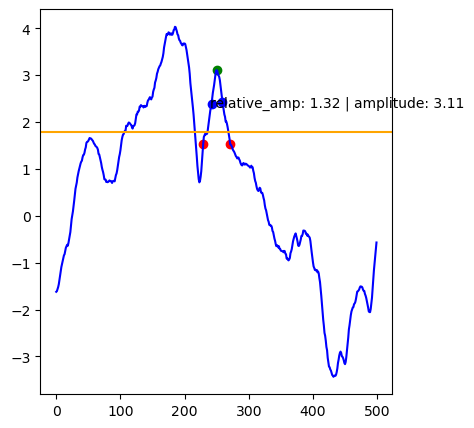

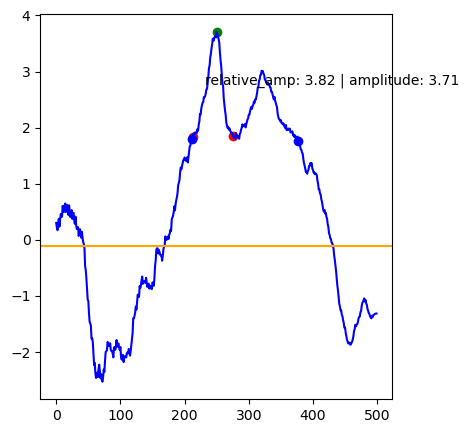

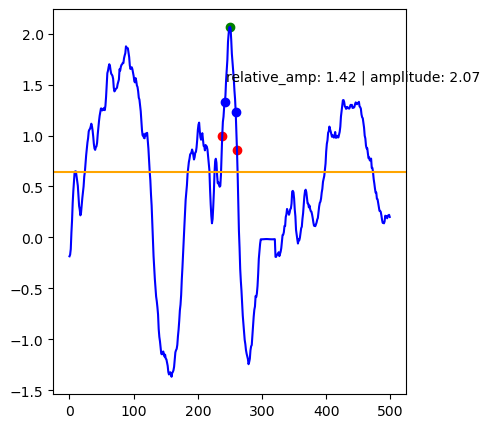

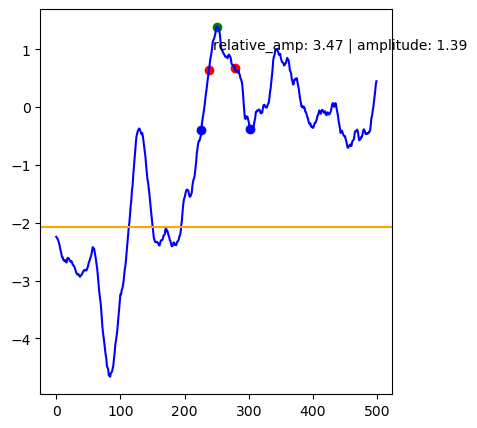

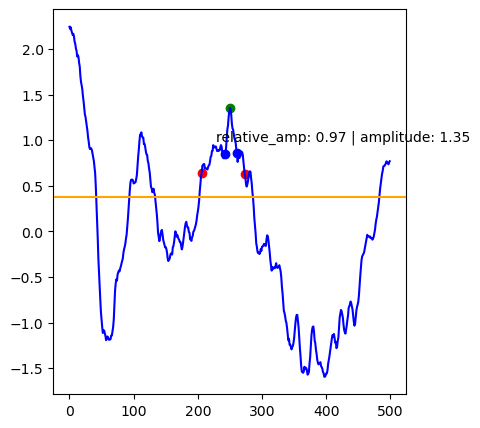

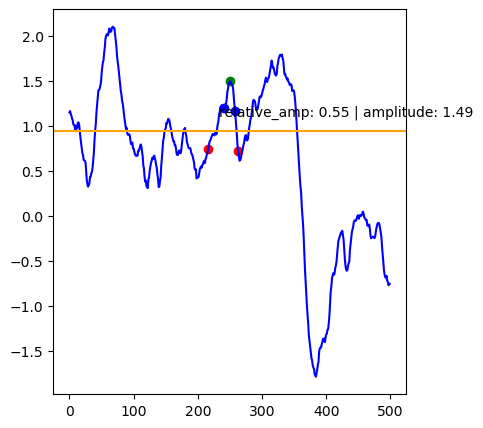

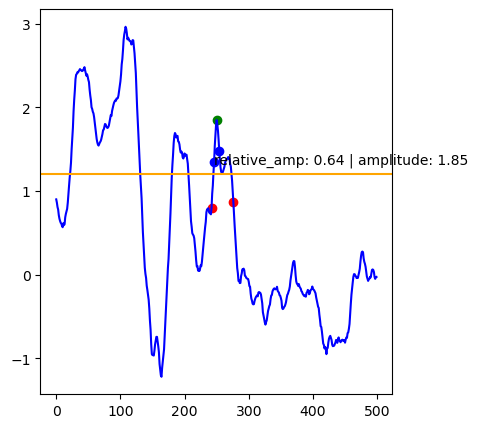

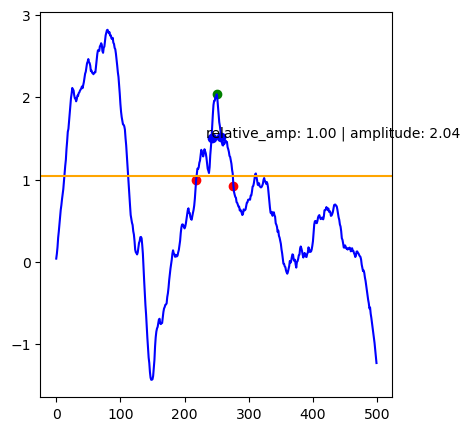

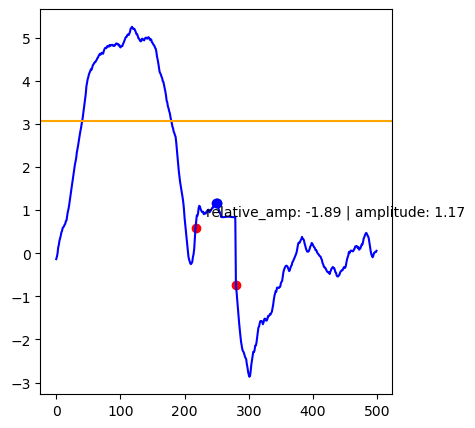

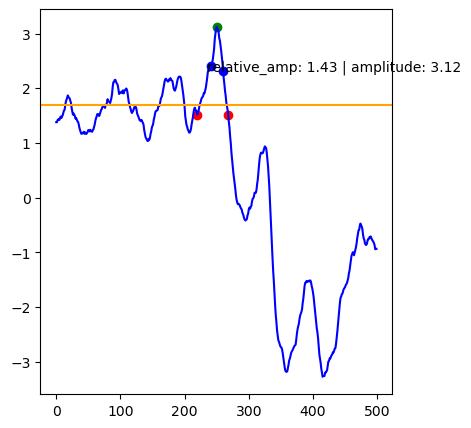

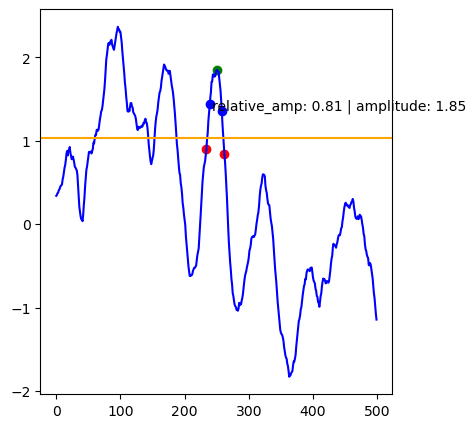

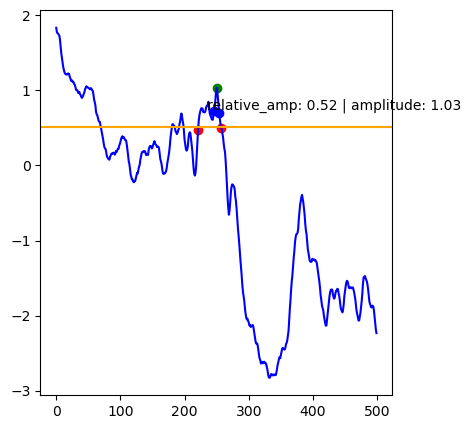

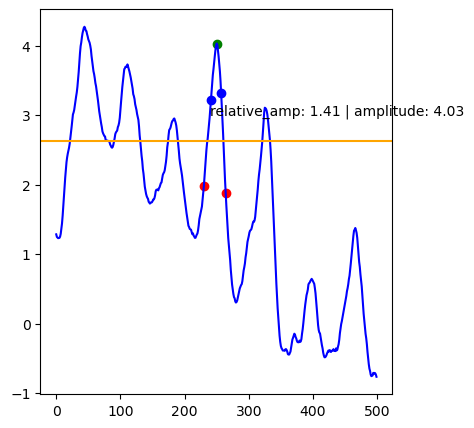

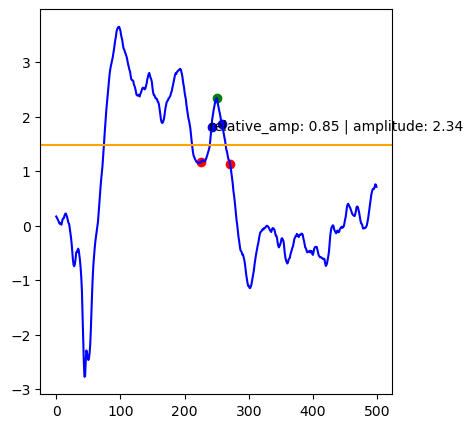

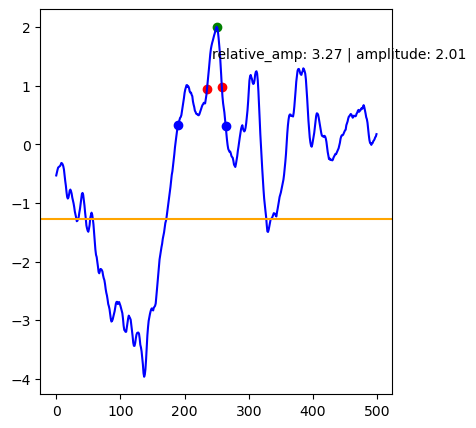

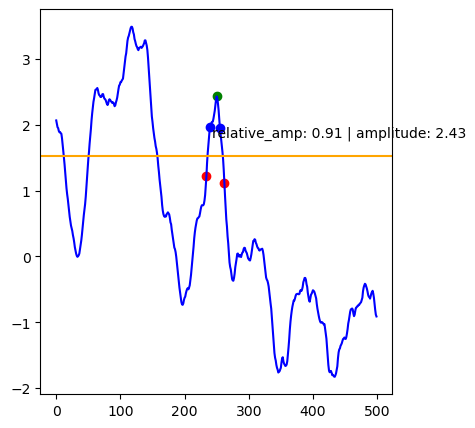

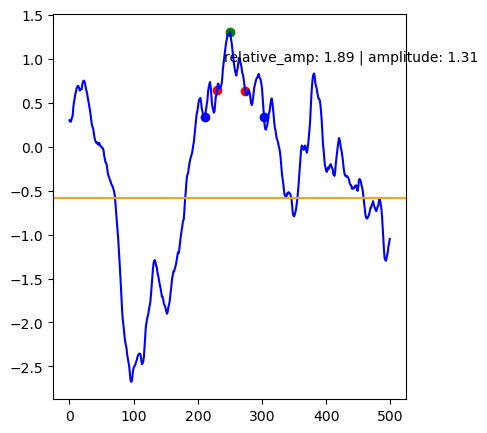

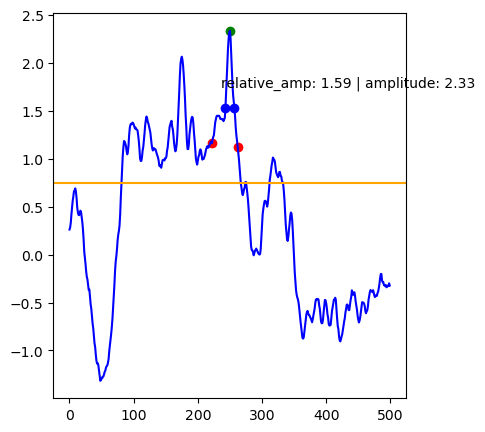

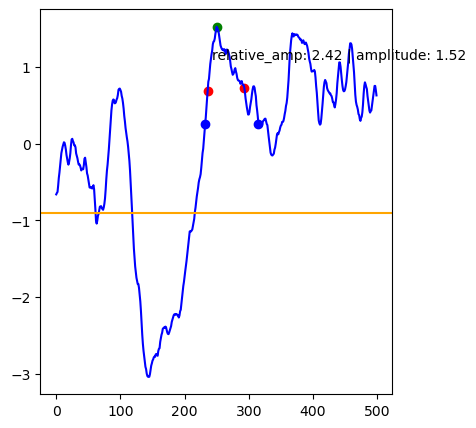

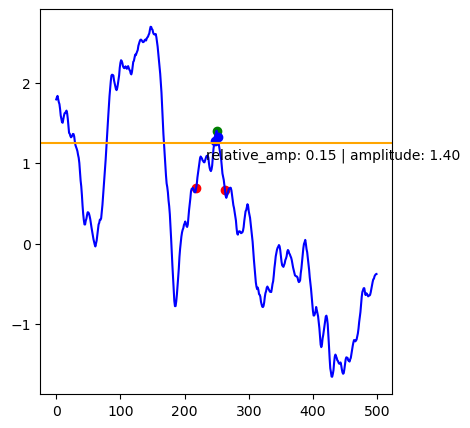

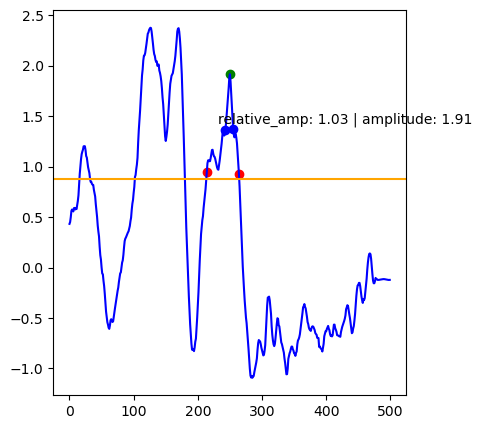

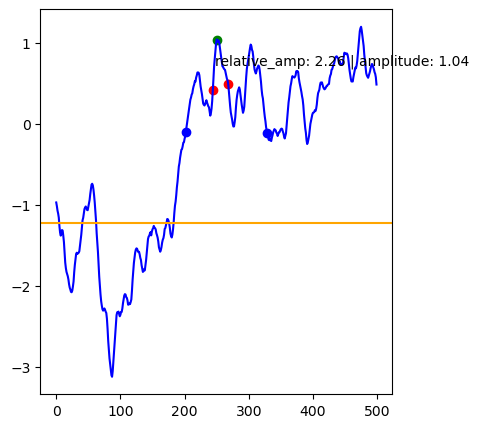

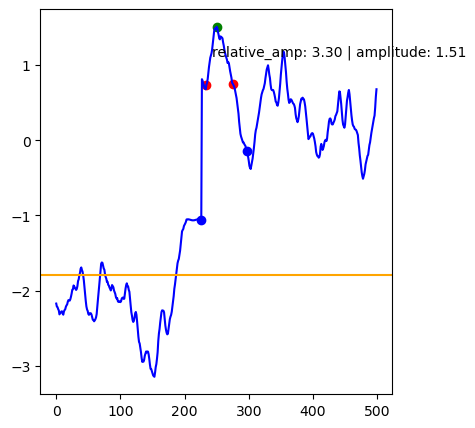

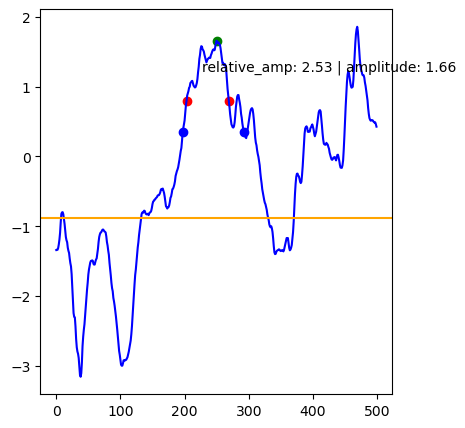

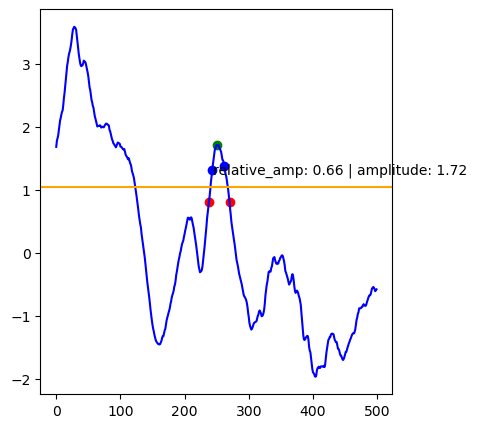

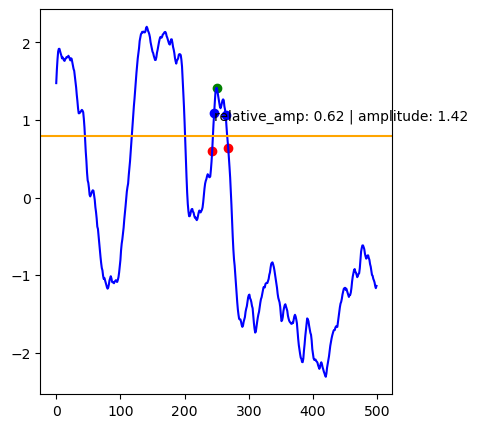

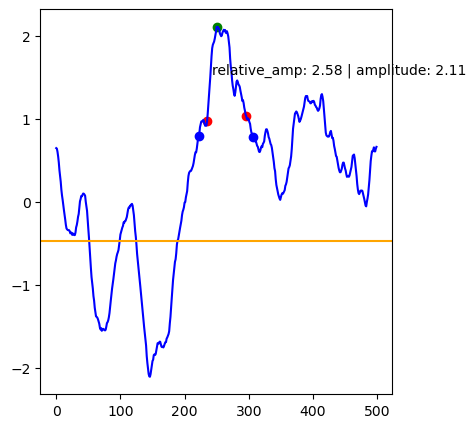

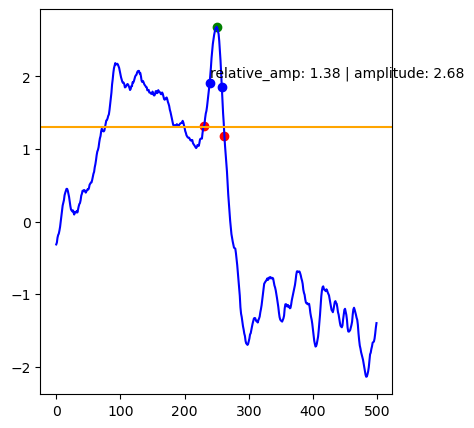

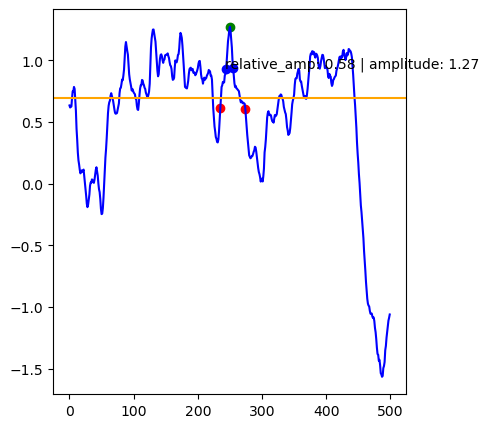

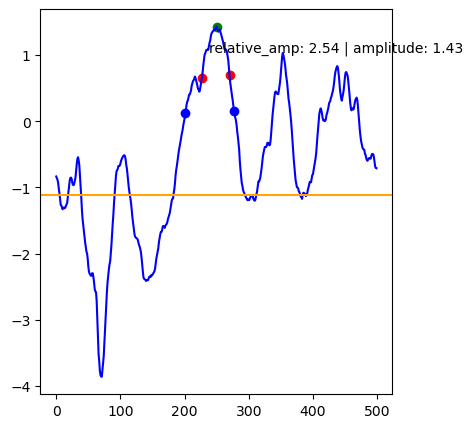

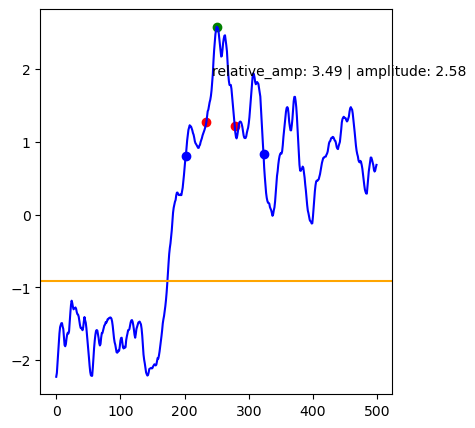

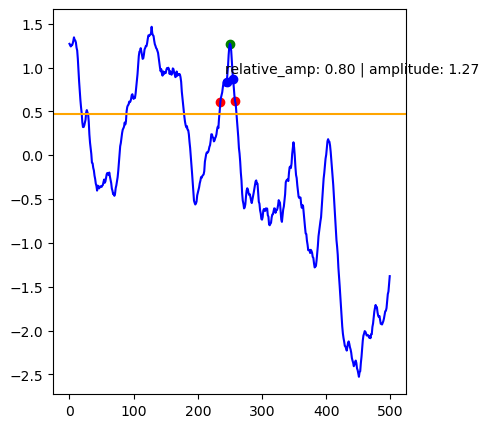

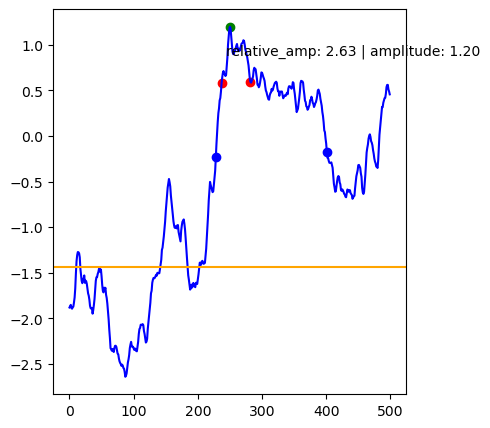

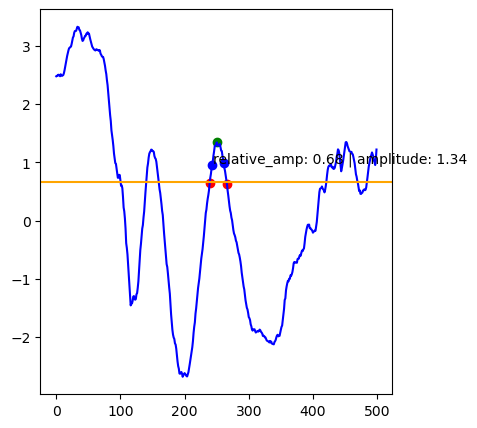

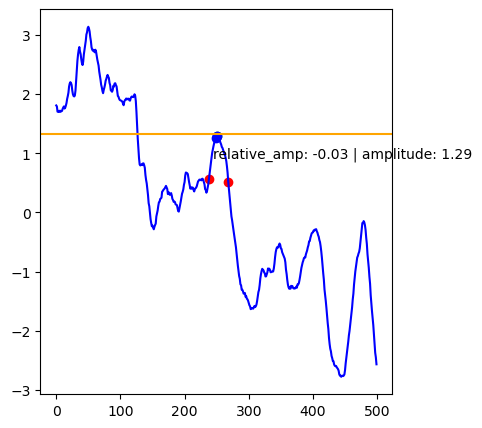

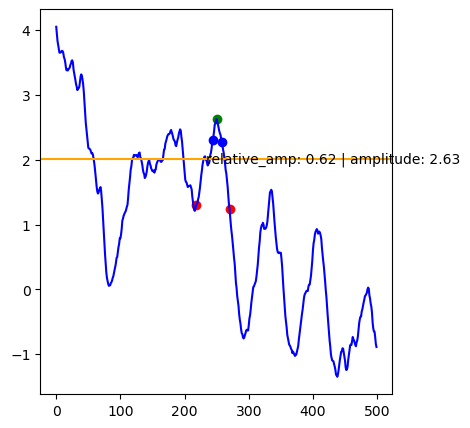

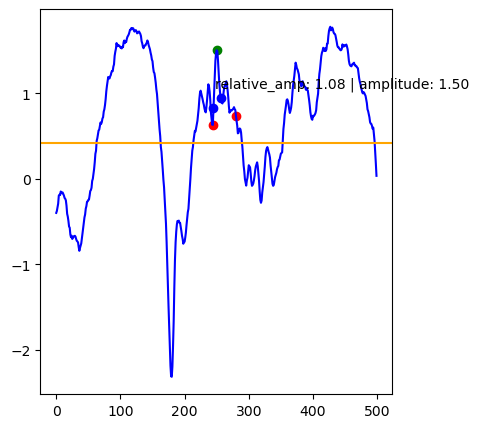

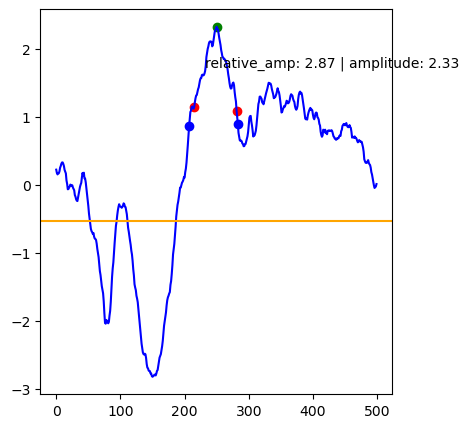

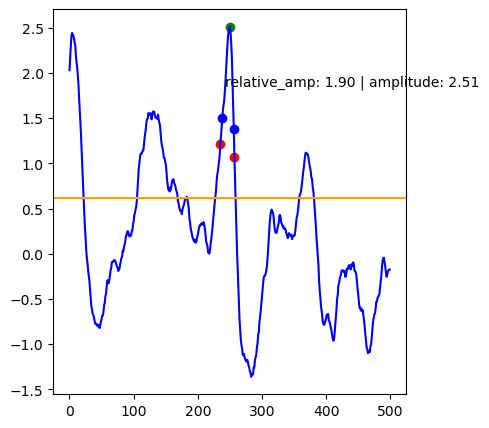

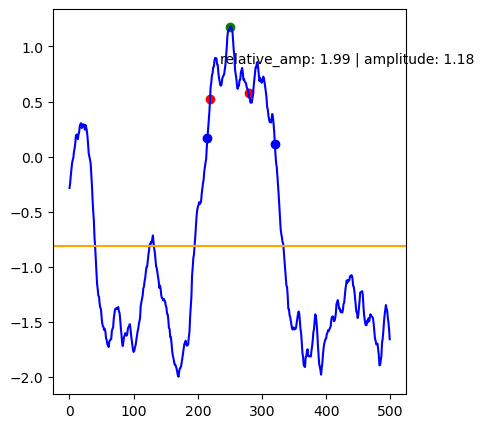

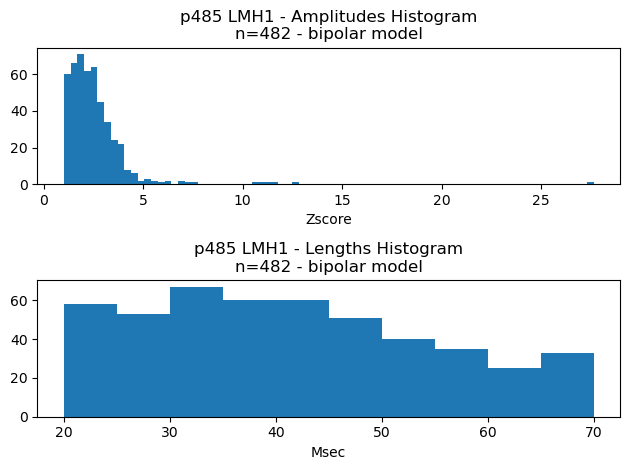

In [90]:

channel_raw = raw_electrode.copy().pick_channels([channel_name])
channel_raw.load_data()
filtered_channel_raw = channel_raw.copy()
filtered_channel_data = channel_raw.get_data()[0]
filtered_channel_data = sp_stats.zscore(filtered_channel_data)
channel_spikes_windows = spikes_windows[channel_name]
channel_spikes_indexes = utils.get_spikes_peak_indexes_in_spikes_windows(filtered_channel_data, channel_spikes_windows)
amplitudes, lengths, angles, relative_amp, relative_length = extract_spikes_peaks_features(filtered_channel_data, channel_spikes_indexes)

plotting.create_channel_features_histograms(subject, amplitudes, lengths, channel_name)


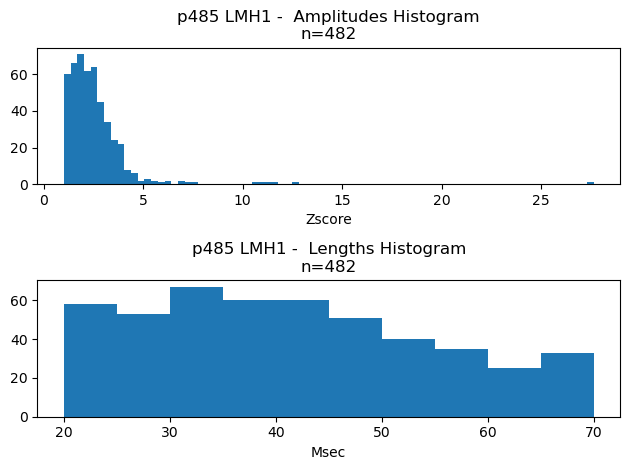

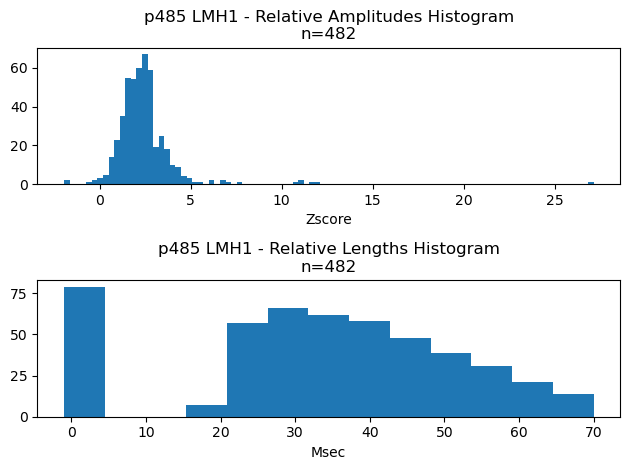

In [72]:
def create_channel_features_histograms(subject: Subject, amplitudes: np.ndarray,
                                       lengths: np.ndarray, channel_name: str, show: bool = False, is_relative: bool = False):

    fig, ax = plt.subplots(2)
    ax[0].hist(amplitudes, bins='auto')
    t = "Relative" if is_relative else ""
    ax[0].set_title(f'{subject.name} {channel_name} - {t} Amplitudes Histogram\nn={len(amplitudes)}')
    ax[0].set_xlabel('Zscore')
    ax[1].hist(lengths, bins='auto')
    ax[1].set_title(f'{subject.name} {channel_name} - {t} Lengths Histogram\nn={len(amplitudes)}')
    ax[1].set_xlabel('Msec')
    fig.tight_layout()
    plt.savefig(os.path.join(subject.paths.subject_histogram_plots_dir_path, f'{subject.name}-{channel_name}.png'),  dpi=1000)
    if show:
        plt.show()
        
create_channel_features_histograms(subject, amplitudes, lengths, channel_name)
create_channel_features_histograms(subject, relative_amp, relative_length, channel_name, is_relative=True)